# Capstone Project - The Battle of Neighbourhoods: Should I move from Lausanne to Bern?
Christopher Tse, Dec 2019
Compare Lausanne and Bern, and using data science techniques determine which neighbourhood would be best for me and explain why.

## Introduction
I am a highly qualified biotech scientist living in Switzerland. I'm currently living in a city called Lausanne, on the French-speaking side of Switzerland, but there may be more job and life opportunities in a German-speaking city called Bern in Switzerland. Bern is very popular among consultancy, biotech and pharmaceutical companies and I want to use data science to help me decide which city would suit me best to live.

I want to compare the livability of the two cities through using similar methods that have been used in the assignments from this course, and help me decide which area would be best for me - a young adult. This project would also be of interest for other individuals individuals and organisations who are interested in assessing these two cities for business and living. 

## Data

In this project, I will use Foursquare data to compare the most interesting regions of Lausanne and Bern. This will be done with k-means to segment and cluster related neighbourhoods to allow me to estimate the suitable demographic to live there. I will be interested in areas which are suitable for a young adult demographic which would include social venues and public transport access for example.
The use of folium interactive maps would be very useful here also so I can visually see attractive features like rivers and parks in the respective areas to strengthen the validity of my recommendations.

There is a limit to how many venues each query can retrieve (up to 113), therefore I will need to break up my query into several queries to cover as much of each city as possible. 
A local governmnet-run supermarket chain called Migros are well distributed across all cities to provide the sale of groceries to the local populations. I will use these as local "neighbourhoods" to capture as many venues as possible. 

Using Foursquare, I first start at the train stations from each city. From the train station, I select all Migros supermarkets nearby. From each Migros supermarket, I list out all nearby venues and analyse each of these "neighbourhoods". 


## Methodology
### Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


### Define Foursquare credentials and version

In [34]:
CLIENT_ID = '' # your Foursquare ID, not shown for privacy
CLIENT_SECRET = '' # your Foursquare Secret, not shown for privacy
VERSION = '20180604'
LIMIT = 50
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


### For each city, I will start with the train station, and from there, select all nearby Migros supermarkets.

In [3]:
address = '3008 Bern'
# For my work in Bern, I will find '3008 Bern'
# Place de la Gare 5A, 1003 Lausanne
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)
print(location)

46.9482713 7.4514512
Bern, Verwaltungskreis Bern-Mittelland, Verwaltungsregion Bern-Mittelland, Bern/Berne, Switzerland


### Having the location data, I can now use the Foursquare API to find all the Migros venues around the station. I set a radius of 1000, and previously had set the limit to 50 venues. 

In [4]:
search_query = 'Migros'
radius = 10000
print(search_query + ' .... OK!')

Migros .... OK!


### Define the corresponding URL

In [5]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=OHYIJKDCMRFM0YTYCZRJHC5H2I5ZA51HU41EU5LK1W5PVAPS&client_secret=G2KF03HSYHCLVCHN11ZBGR5GZDVKBYOG2UVF20X4BPQLQ15G&ll=46.9482713,7.4514512&v=20180604&query=Migros&radius=10000&limit=50'

### Send the GET Request and examine the results

In [6]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5dfa5eb2dd0f85001b9aa05f'},
 'response': {'venues': [{'id': '4b644e06f964a5208ba92ae3',
    'name': 'Migros',
    'location': {'address': 'Marktgasse 46',
     'lat': 46.94813202006709,
     'lng': 7.444727765228771,
     'labeledLatLngs': [{'label': 'display',
       'lat': 46.94813202006709,
       'lng': 7.444727765228771}],
     'distance': 511,
     'postalCode': '3011',
     'cc': 'CH',
     'city': 'Bern',
     'state': 'Bern',
     'country': 'Schweiz',
     'formattedAddress': ['Marktgasse 46', '3011 Bern', 'Schweiz']},
    'categories': [{'id': '52f2ab2ebcbc57f1066b8b46',
      'name': 'Supermarket',
      'pluralName': 'Supermarkets',
      'shortName': 'Supermarket',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1576689524',
    'hasPerk': False},
   {'id': '4cbdc993dd41a35d2720fba0',
    'name': 'Migros Christoffel',
    'loc

### Get relevant part of JSON and transform it into a *pandas* dataframe

In [7]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head(50)

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId
0,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",False,4b644e06f964a5208ba92ae3,Marktgasse 46,CH,Bern,Schweiz,NaN,511,"[Marktgasse 46, 3011 Bern, Schweiz]","[{'label': 'display', 'lat': 46.94813202006709...",46.948132,7.444728,NaN,3011,Bern,Migros,v-1576689524
1,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",False,4cbdc993dd41a35d2720fba0,Bahnhof Bern,CH,Bern,Schweiz,RailCity Christoffelunterführung,837,[Bahnhof Bern (RailCity Christoffelunterführun...,"[{'label': 'display', 'lat': 46.9475846171591,...",46.947585,7.440479,NaN,3011,Bern,Migros Christoffel,v-1576689524
2,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",False,4b5f1cb1f964a520baa629e3,Zähringerstr. 43,CH,Bern,Schweiz,NaN,1536,"[Zähringerstr. 43, 3012 Bern, Schweiz]","[{'label': 'display', 'lat': 46.95521840964324...",46.955218,7.433974,NaN,3012,Bern,Migros,v-1576689524
3,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",False,4b6f2023f964a520bdde2ce3,Bahnhof Bern,CH,Bern,Schweiz,RailCity Galerie,881,"[Bahnhof Bern (RailCity Galerie), 3011 Bern, S...","[{'label': 'display', 'lat': 46.94925357896667...",46.949254,7.439941,NaN,3011,Bern,Migros Bern-Bahnhof,v-1576689524
4,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",False,4cbf178d00d837046fbb415c,Thunstr. 18,CH,Bern,Schweiz,NaN,666,"[Thunstr. 18, 3005 Bern, Schweiz]","[{'label': 'display', 'lat': 46.94238893196707...",46.942389,7.453110,NaN,3005,Bern,Migros,v-1576689524
5,"[{'id': '4bf58dd8d48988d1a2941735', 'name': 'C...",False,4da717fe0cb66f658712fbb3,Marktgasse 46,CH,Bern,Schweiz,NaN,496,"[Marktgasse 46, 3011 Bern, Schweiz]","[{'label': 'display', 'lat': 46.94813499952044...",46.948135,7.444923,NaN,3011,Bern,Klubschule Migros,v-1576689524
6,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",False,4b7acda1f964a520923d2fe3,Bubenbergplatz 8,CH,Bern,Schweiz,NaN,1043,"[Bubenbergplatz 8, 3011 Bern, Schweiz]","[{'label': 'display', 'lat': 46.94729427209867...",46.947294,7.437797,NaN,3011,Bern,Migros,v-1576689524
7,"[{'id': '4bf58dd8d48988d1fd941735', 'name': 'S...",False,4eda35064901c8be1d4a50a0,Wankdorffeldstr. 71,CH,Bern,Schweiz,Wyler,2113,"[Wankdorffeldstr. 71 (Wyler), 3014 Bern, Schweiz]","[{'label': 'display', 'lat': 46.96546718575483...",46.965467,7.463245,NaN,3014,Bern,Migros,v-1576689524
8,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",False,4b7cee3cf964a5208ca92fe3,Egghölzlistr. 1a,CH,Bern,Schweiz,NaN,2505,"[Egghölzlistr. 1a, 3006 Bern, Schweiz]","[{'label': 'display', 'lat': 46.93509110788873...",46.935091,7.478171,NaN,3006,Bern,Migros,v-1576689524
9,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",False,4d6923161b63a1cdb6933b2d,Seftigenstr. 1,CH,Bern,Schweiz,Eigerplatz,1749,"[Seftigenstr. 1 (Eigerplatz), 3007 Bern, Schweiz]","[{'label': 'display', 'lat': 46.94017070967135...",46.940171,7.431724,NaN,3007,Bern,Migros,v-1576689524


### Define information of interest and filter dataframe

In [8]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Migros,Supermarket,Marktgasse 46,CH,Bern,Schweiz,NaN,511,"[Marktgasse 46, 3011 Bern, Schweiz]","[{'label': 'display', 'lat': 46.94813202006709...",46.948132,7.444728,NaN,3011,Bern,4b644e06f964a5208ba92ae3
1,Migros Christoffel,Supermarket,Bahnhof Bern,CH,Bern,Schweiz,RailCity Christoffelunterführung,837,[Bahnhof Bern (RailCity Christoffelunterführun...,"[{'label': 'display', 'lat': 46.9475846171591,...",46.947585,7.440479,NaN,3011,Bern,4cbdc993dd41a35d2720fba0
2,Migros,Supermarket,Zähringerstr. 43,CH,Bern,Schweiz,NaN,1536,"[Zähringerstr. 43, 3012 Bern, Schweiz]","[{'label': 'display', 'lat': 46.95521840964324...",46.955218,7.433974,NaN,3012,Bern,4b5f1cb1f964a520baa629e3
3,Migros Bern-Bahnhof,Supermarket,Bahnhof Bern,CH,Bern,Schweiz,RailCity Galerie,881,"[Bahnhof Bern (RailCity Galerie), 3011 Bern, S...","[{'label': 'display', 'lat': 46.94925357896667...",46.949254,7.439941,NaN,3011,Bern,4b6f2023f964a520bdde2ce3
4,Migros,Grocery Store,Thunstr. 18,CH,Bern,Schweiz,NaN,666,"[Thunstr. 18, 3005 Bern, Schweiz]","[{'label': 'display', 'lat': 46.94238893196707...",46.942389,7.453110,NaN,3005,Bern,4cbf178d00d837046fbb415c
5,Klubschule Migros,Community College,Marktgasse 46,CH,Bern,Schweiz,NaN,496,"[Marktgasse 46, 3011 Bern, Schweiz]","[{'label': 'display', 'lat': 46.94813499952044...",46.948135,7.444923,NaN,3011,Bern,4da717fe0cb66f658712fbb3
6,Migros,Grocery Store,Bubenbergplatz 8,CH,Bern,Schweiz,NaN,1043,"[Bubenbergplatz 8, 3011 Bern, Schweiz]","[{'label': 'display', 'lat': 46.94729427209867...",46.947294,7.437797,NaN,3011,Bern,4b7acda1f964a520923d2fe3
7,Migros,Shopping Mall,Wankdorffeldstr. 71,CH,Bern,Schweiz,Wyler,2113,"[Wankdorffeldstr. 71 (Wyler), 3014 Bern, Schweiz]","[{'label': 'display', 'lat': 46.96546718575483...",46.965467,7.463245,NaN,3014,Bern,4eda35064901c8be1d4a50a0
8,Migros,Grocery Store,Egghölzlistr. 1a,CH,Bern,Schweiz,NaN,2505,"[Egghölzlistr. 1a, 3006 Bern, Schweiz]","[{'label': 'display', 'lat': 46.93509110788873...",46.935091,7.478171,NaN,3006,Bern,4b7cee3cf964a5208ca92fe3
9,Migros,Grocery Store,Seftigenstr. 1,CH,Bern,Schweiz,Eigerplatz,1749,"[Seftigenstr. 1 (Eigerplatz), 3007 Bern, Schweiz]","[{'label': 'display', 'lat': 46.94017070967135...",46.940171,7.431724,NaN,3007,Bern,4d6923161b63a1cdb6933b2d


### Let's visualize the venues that are in Lausanne, with a focus from the train station

In [9]:
dataframe_filtered.name

0                          Migros
1              Migros Christoffel
2                          Migros
3             Migros Bern-Bahnhof
4                          Migros
5               Klubschule Migros
6                          Migros
7                          Migros
8                          Migros
9                          Migros
10                         Migros
11              Klubschule Migros
12                         Migros
13              Klubschule Migros
14                         Migros
15          Migros Do It + Garden
16                     Migros VOI
17          Do It + Garden Migros
18              Migros Restaurant
19               Migros Take Away
20                         Migros
21                         Migros
22                   Migros Daily
23                         Migros
24                         Migros
25                     Migros VOI
26               Migros Take Away
27                    Migros Bank
28                         Migros
29            

In [10]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the train sation
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Lausanne Gare',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the venues as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

### Let's create a function to repeat the same process to all the areas near a Mirgos in Lausanne

In [11]:
#
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Now we write the code to run the above function on each neighborhood and create a new dataframe called *lausanne_areas*, with the unique ID of each Migros store

In [12]:
lausanne_areas = getNearbyVenues(names=dataframe_filtered['id'],
                                   latitudes=dataframe_filtered['lat'],
                                   longitudes=dataframe_filtered['lng']
                                  )

4b644e06f964a5208ba92ae3
4cbdc993dd41a35d2720fba0
4b5f1cb1f964a520baa629e3
4b6f2023f964a520bdde2ce3
4cbf178d00d837046fbb415c
4da717fe0cb66f658712fbb3
4b7acda1f964a520923d2fe3
4eda35064901c8be1d4a50a0
4b7cee3cf964a5208ca92fe3
4d6923161b63a1cdb6933b2d
4b51ead6f964a520385b27e3
4cc930035c17b60c9ea30705
4b75b135f964a520661d2ee3
4d7665b888235481ad046a8c
52dcd06311d23f81f2998b26
4bd046df046076b0a69d6f71
53ec9a0b498e318087cc0186
4bf564cbff90c9b69d4d5628
4d81eb80c8bdb1f7a5aed2c2
4b7a85a3f964a520bb2f2fe3
530de9db498e5909d3f5ba68
4cbff5b0020d468836756538
59def3e0e55d8b6365bb9ed9
4d94b1b33048b1f7af213764
4c74e2953adda143afbf05af
4eaed0bc7ee59f16098555fd
5422a3de498ee9964a114d75
52fb94fe498e1ff912412882
53272ee9498ec7c75fe39d63
50cf0feae4b0c490cfcc597d
4cf79ed0e308236a2b63ecac
4bee662ce8c3c9288ea89892
4d13025f2e58370486d2e8d1
57778ed838fad7362ffc78a9
4b58503cf964a520425228e3
4d8ddaa1788c5481e32b2afd
4dcbef3052b17cba4fb31068
4d9459ae98c88cfac1ac1949
4ec65d8a0e6158bafd288ac4
56027f5b498e5def6f49523d


### Let's check the size of the resulting dataframe

In [13]:
print(lausanne_areas.shape)
lausanne_areas.head()

(1618, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,4b644e06f964a5208ba92ae3,46.948132,7.444728,Bundesplatz,46.947414,7.443817,Plaza
1,4b644e06f964a5208ba92ae3,46.948132,7.444728,Adriano's Bar & Café,46.947914,7.447428,Café
2,4b644e06f964a5208ba92ae3,46.948132,7.444728,Zytglogge,46.948084,7.447555,Monument / Landmark
3,4b644e06f964a5208ba92ae3,46.948132,7.444728,Bellevue Palace Bern,46.946799,7.446866,Hotel
4,4b644e06f964a5208ba92ae3,46.948132,7.444728,Café-Bar Turnhalle,46.950284,7.443385,Bar


In [14]:
print('There are {} uniques categories.'.format(len(lausanne_areas['Venue Category'].unique())))

There are 129 uniques categories.


In [15]:
# one hot encoding
lausanne_onehot = pd.get_dummies(lausanne_areas[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
lausanne_onehot['Neighborhood'] = lausanne_areas['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [lausanne_onehot.columns[-1]] + list(lausanne_onehot.columns[:-1])
lausanne_onehot = lausanne_onehot[fixed_columns]

lausanne_onehot.head()

,Zoo Exhibit,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Garage,Bagel Shop,Bakery,Bar,Bathing Area,Bed & Breakfast,Beer Garden,Big Box Store,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Line,Bus Station,Bus Stop,Café,Campground,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convention Center,Coworking Space,Creperie,Cupcake Shop,Department Store,Dessert Shop,Discount Store,Electronics Store,Event Space,Fast Food Restaurant,Flower Shop,Food,Food & Drink Shop,Food Truck,Forest,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Historic Site,History Museum,Hockey Arena,Hockey Field,Home Service,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Jazz Club,Lake,Laundry Service,Light Rail Station,Liquor Store,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Multiplex,Music Venue,Neighborhood,Nightclub,Office,Park,Performing Arts Venue,Pharmacy,Pizza Place,Plaza,Pool,Ramen Restaurant,Rental Car Location,Restaurant,Rock Club,Sandwich Place,Scenic Lookout,Science Museum,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Track,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Zoo
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4b644e06f964a5208ba92ae3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4b644e06f964a5208ba92ae3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4b644e06f964a5208ba92ae3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4b644e06f964a5208ba92ae3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4b644e06f964a5208ba92ae3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Let's check how many venues were returned for each neighborhood

In [16]:
lausanne_onehot.shape

(1618, 129)

In [17]:
lausanne_grouped = lausanne_onehot.groupby('Neighborhood').mean().reset_index()
lausanne_grouped

,Neighborhood,Zoo Exhibit,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Garage,Bagel Shop,Bakery,Bar,Bathing Area,Bed & Breakfast,Beer Garden,Big Box Store,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Line,Bus Station,Bus Stop,Café,Campground,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convention Center,Coworking Space,Creperie,Cupcake Shop,Department Store,Dessert Shop,Discount Store,Electronics Store,Event Space,Fast Food Restaurant,Flower Shop,Food,Food & Drink Shop,Food Truck,Forest,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Historic Site,History Museum,Hockey Arena,Hockey Field,Home Service,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Jazz Club,Lake,Laundry Service,Light Rail Station,Liquor Store,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Multiplex,Music Venue,Nightclub,Office,Park,Performing Arts Venue,Pharmacy,Pizza Place,Plaza,Pool,Ramen Restaurant,Rental Car Location,Restaurant,Rock Club,Sandwich Place,Scenic Lookout,Science Museum,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Track,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Zoo
0,4b51ead6f964a520385b27e3,0.000000,0.00,0.000000,0.0,0.055556,0.0,0.00,0.000000,0.000000,0.00,0.055556,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.222222,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.0,0.00,0.00,0.00,0.00,0.055556,0.00,0.000000,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.055556,0.000000,0.055556,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.055556,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.111111,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.111111,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000
1,4b58503cf964a520425228e3,0.000000,0.00,0.000000,0.0,0.045455,0.0,0.00,0.045455,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.045455,0.00,0.0,0.00,0.00,0.00,0.00,0.045455,0.00,0.000000,0.000000,0.00,0.090909,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.090909,0.000000,0.045455,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.045455,0.00,0.0,0.000000,0.045455,0.00,0.000000,0.000000,0.045455,0.00,0.000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.045455,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.136364,0.045455,0.045455,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.045455,0.00,0.000000
2,4b5f1cb1f964a520baa629e3,0.000000,0.00,0.020000,0.0,0.000000,0.0,0.02,0.000000,0.140000,0.00,0.000000,0.000000,0.000000,0.000000,0.02,0.00,0.00,0.000000,0.000000,0.02,0.000000,0.000000,0.0,0.080000,0.000000,0.000000,0.00,0.020000,0.02,0.000000,0.00,0.0,0.00,0.00,0.04,0.02,0.020000

### Let's print each neighborhood along with the top 5 most common venues

In [18]:
num_top_venues = 5

for hood in lausanne_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = lausanne_grouped[lausanne_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----4b51ead6f964a520385b27e3----
             venue  freq
0      Bus Station  0.22
1      Supermarket  0.11
2       Food Truck  0.11
3    Train Station  0.11
4  Bed & Breakfast  0.06


----4b58503cf964a520425228e3----
                  venue  freq
0           Supermarket  0.14
1  Fast Food Restaurant  0.09
2         Grocery Store  0.09
3                  Park  0.05
4    Light Rail Station  0.05


----4b5f1cb1f964a520baa629e3----
                venue  freq
0                 Bar  0.14
1  Italian Restaurant  0.10
2                Café  0.08
3          Restaurant  0.08
4                Park  0.04


----4b644e06f964a5208ba92ae3----
                venue  freq
0  Italian Restaurant  0.10
1                Café  0.08
2               Plaza  0.08
3                Park  0.06
4                 Bar  0.06


----4b6f2023f964a520bdde2ce3----
                venue  freq
0  Italian Restaurant  0.08
1               Plaza  0.08
2                Café  0.06
3                Park  0.06
4          Restaurant

### Let's put that into a *pandas* dataframe

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = lausanne_grouped['Neighborhood']

for ind in np.arange(lausanne_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(lausanne_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4b51ead6f964a520385b27e3,Bus Station,Train Station,Food Truck,Supermarket,Pool,Shopping Mall,Bed & Breakfast,Department Store,Asian Restaurant,Grocery Store
1,4b58503cf964a520425228e3,Supermarket,Fast Food Restaurant,Grocery Store,Italian Restaurant,Department Store,Mexican Restaurant,Frozen Yogurt Shop,Sushi Restaurant,Swiss Restaurant,Light Rail Station
2,4b5f1cb1f964a520baa629e3,Bar,Italian Restaurant,Café,Restaurant,Creperie,Park,Bookstore,Hotel Bar,Department Store,Art Museum
3,4b644e06f964a5208ba92ae3,Italian Restaurant,Plaza,Café,Bar,Park,Hotel,Restaurant,Swiss Restaurant,Gourmet Shop,Hotel Bar
4,4b6f2023f964a520bdde2ce3,Italian Restaurant,Plaza,Park,Restaurant,Café,Creperie,Hotel,Swiss Restaurant,Bar,Clothing Store


## Cluster Neighborhoods
Now I check the similarities of each neighbourhood with one another using k clusters 

In [22]:
# Cluster using K-means
# First, see how different k value affects the clustering in terms of 'inertia'
k_min, k_max = 2, 20
lausanne_grouped_clustering = lausanne_grouped.drop('Neighborhood', 1)
inertia_list = []

for k in range(k_min, k_max+1):
    kmeans = KMeans(init = 'k-means++', n_clusters = k, n_init = 12)
    kmeans.fit(lausanne_grouped_clustering)
    inertia_list.append(kmeans.inertia_)
    print('k={}: inertia={}'.format(k,kmeans.inertia_))
# run k-means clustering


# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10]

k=2: inertia=2.2177865136521695
k=3: inertia=1.9237189673132402
k=4: inertia=1.7955962803098644
k=5: inertia=1.5888741498311725
k=6: inertia=1.4208538014675898
k=7: inertia=1.2622142897979156
k=8: inertia=1.1463554849548425
k=9: inertia=1.0650146131596485
k=10: inertia=0.9549370516755413
k=11: inertia=0.7989863411435746
k=12: inertia=0.7322024935879464
k=13: inertia=0.6479950594211594
k=14: inertia=0.5636032150451378
k=15: inertia=0.499738805133194
k=16: inertia=0.4156737354253616
k=17: inertia=0.36247340903259007
k=18: inertia=0.32053734420586877
k=19: inertia=0.28334383790068074
k=20: inertia=0.23914354668555404


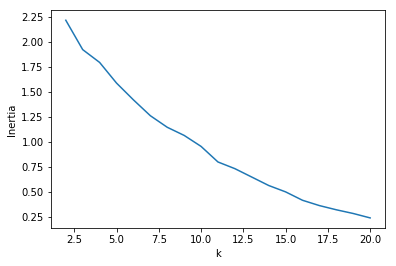

In [23]:
k_list = list(range(k_min,k_max+1))
plt.xlabel('k')
plt.ylabel('Inertia')
fig = plt.plot(np.array(k_list), np.array(inertia_list))
plt.savefig('inertia plot.png')

In [24]:
# set number of clusters
kclusters = 8

lausanne_grouped_clustering = lausanne_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(lausanne_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([6, 5, 1, 1, 1, 0, 1, 1, 3, 5], dtype=int32)

In [26]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4b51ead6f964a520385b27e3,Bus Station,Train Station,Food Truck,Supermarket,Pool,Shopping Mall,Bed & Breakfast,Department Store,Asian Restaurant,Grocery Store
1,4b58503cf964a520425228e3,Supermarket,Fast Food Restaurant,Grocery Store,Italian Restaurant,Department Store,Mexican Restaurant,Frozen Yogurt Shop,Sushi Restaurant,Swiss Restaurant,Light Rail Station
2,4b5f1cb1f964a520baa629e3,Bar,Italian Restaurant,Café,Restaurant,Creperie,Park,Bookstore,Hotel Bar,Department Store,Art Museum
3,4b644e06f964a5208ba92ae3,Italian Restaurant,Plaza,Café,Bar,Park,Hotel,Restaurant,Swiss Restaurant,Gourmet Shop,Hotel Bar
4,4b6f2023f964a520bdde2ce3,Italian Restaurant,Plaza,Park,Restaurant,Café,Creperie,Hotel,Swiss Restaurant,Bar,Clothing Store
5,4b75b135f964a520661d2ee3,Gym,Supermarket,Restaurant,Discount Store,Bistro,Bus Station,Swiss Restaurant,Soccer Field,Turkish Restaurant,Grocery Store
6,4b7a85a3f964a520bb2f2fe3,Italian Restaurant,Plaza,Park,Restaurant,Café,Creperie,Hotel,Swiss Restaurant,Bar,Clothing Store
7,4b7acda1f964a520923d2fe3,Plaza,Italian Restaurant,Park,Café,Coffee Shop,Monument / Landmark,Vegetarian / Vegan Restaurant,Hotel,Creperie,Restaurant
8,4b7cee3cf964a5208ca92fe3,Supermarket,Tram Station,Construction & Landscaping,Park,Hotel,Grocery Store,Bus Stop,Electronics Store,Flower Shop,Fast Food Restaurant
9,4bd046df046076b0a69d6f71,Italian Restaurant,Hotel,French Restaurant,Bakery,Restaurant,Shopping Mall,Stadium,Supermarket,Swiss Restaurant,Bus Station


In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

lausanne_merged = dataframe_filtered

# merge lausanne_grouped with lausanne_data to add latitude/longitude for each neighborhood
lausanne_merged = lausanne_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='id')
#dataframe_filtered
lausanne_merged

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Migros,Supermarket,Marktgasse 46,CH,Bern,Schweiz,NaN,511,"[Marktgasse 46, 3011 Bern, Schweiz]","[{'label': 'display', 'lat': 46.94813202006709...",46.948132,7.444728,NaN,3011,Bern,4b644e06f964a5208ba92ae3,1,Italian Restaurant,Plaza,Café,Bar,Park,Hotel,Restaurant,Swiss Restaurant,Gourmet Shop,Hotel Bar
1,Migros Christoffel,Supermarket,Bahnhof Bern,CH,Bern,Schweiz,RailCity Christoffelunterführung,837,[Bahnhof Bern (RailCity Christoffelunterführun...,"[{'label': 'display', 'lat': 46.9475846171591,...",46.947585,7.440479,NaN,3011,Bern,4cbdc993dd41a35d2720fba0,1,Plaza,Italian Restaurant,Café,Park,Bar,Hotel,Restaurant,Pizza Place,Swiss Restaurant,Gourmet Shop
2,Migros,Supermarket,Zähringerstr. 43,CH,Bern,Schweiz,NaN,1536,"[Zähringerstr. 43, 3012 Bern, Schweiz]","[{'label': 'display', 'lat': 46.95521840964324...",46.955218,7.433974,NaN,3012,Bern,4b5f1cb1f964a520baa629e3,1,Bar,Italian Restaurant,Café,Restaurant,Creperie,Park,Bookstore,Hotel Bar,Department Store,Art Museum
3,Migros Bern-Bahnhof,Supermarket,Bahnhof Bern,CH,Bern,Schweiz,RailCity Galerie,881,"[Bahnhof Bern (RailCity Galerie), 3011 Bern, S...","[{'label': 'display', 'lat': 46.94925357896667...",46.949254,7.439941,NaN,3011,Bern,4b6f2023f964a520bdde2ce3,1,Italian Restaurant,Plaza,Park,Restaurant,Café,Creperie,Hotel,Swiss Restaurant,Bar,Clothing Store
4,Migros,Grocery Store,Thunstr. 18,CH,Bern,Schweiz,NaN,666,"[Thunstr. 18, 3005 Bern, Schweiz]","[{'label': 'display', 'lat': 46.94238893196707...",46.942389,7.453110,NaN,3005,Bern,4cbf178d00d837046fbb415c,1,Swiss Restaurant,Bar,Café,Plaza,Park,Science Museum,French Restaurant,Coffee Shop,Pizza Place,Performing Arts Venue
5,Klubschule Migros,Community College,Marktgasse 46,CH,Bern,Schweiz,NaN,496,"[Marktgasse 46, 3011 Bern, Schweiz]","[{'label': 'display', 'lat': 46.94813499952044...",46.948135,7.444923,NaN,3011,Bern,4da717fe0cb66f658712fbb3,1,Italian Restaurant,Café,Plaza,Bar,Park,Hotel,Restaurant,Swiss Restaurant,Pizza Place,Hotel Bar
6,Migros,Grocery Store,Bubenbergplatz 8,CH,Bern,Schweiz,NaN,1043,"[Bubenbergplatz 8, 3011 Bern, Schweiz]","[{'label': 'display', 'lat': 46.94729427209867...",46.947294,7.437797,NaN,3011,Bern,4b7acda1f964a520923d2fe3,1,Plaza,Italian Restaurant,Park,Café,Coffee Shop,Monument / Landmark,Vegetarian / Vegan Restaurant,Hotel,Creperie,Restaurant
7,Migros,Shopping Mall,Wankdorffeldstr. 71,CH,Bern,Schweiz,Wyler,2113,"[Wankdorffeldstr. 71 (Wyler), 3014 Bern, Schweiz]","[{'label': 'display', 'lat': 46.96546718575483...",46.965467,7.463245,NaN,3014,Bern,4eda35064901c8be1d4a50a0,5,Restaurant,Italian Restaurant,Stadium,Shopping Mall,Hotel,Supermarket,Tram Station,Swiss Restaurant,Hockey Arena,Plaza
8,Migros,Grocery Store,Egghölzlistr. 1a,CH,Bern,Schweiz,NaN,2505,"[Egghölzlistr. 1a, 3006 Bern, Schweiz]","[{'label': 'display', 'lat': 46.93509110788873...",46.935091,7.478171,NaN,3006,Bern,4b7cee3cf964a5208ca92fe3,3,Supermarket,Tram Station,Construction & Landscaping,Park,Hotel,Grocery Store,Bus Stop,Electronics Store,Flower Shop,Fast Food Restaurant
9,Migros,Grocery Store,Seftigenstr. 1,CH,Bern,Schweiz,Eigerplatz,1749,"[Seftigenstr. 1 (Eigerplatz), 3007 Bern, Schweiz]","[{'label': 'display', 'lat': 46.94017070967135...",46.940171,7.431724,NaN,3007,Bern,4d6923161b63a1cdb6933b2d,5,Pizza Place,Tram Station,Plaza,Supermarket,Swiss Restaurant,Hotel,Gym,Ice Cream Shop,Italian Restaurant,Bakery


In [28]:
lausanne_merged

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Migros,Supermarket,Marktgasse 46,CH,Bern,Schweiz,NaN,511,"[Marktgasse 46, 3011 Bern, Schweiz]","[{'label': 'display', 'lat': 46.94813202006709...",46.948132,7.444728,NaN,3011,Bern,4b644e06f964a5208ba92ae3,1,Italian Restaurant,Plaza,Café,Bar,Park,Hotel,Restaurant,Swiss Restaurant,Gourmet Shop,Hotel Bar
1,Migros Christoffel,Supermarket,Bahnhof Bern,CH,Bern,Schweiz,RailCity Christoffelunterführung,837,[Bahnhof Bern (RailCity Christoffelunterführun...,"[{'label': 'display', 'lat': 46.9475846171591,...",46.947585,7.440479,NaN,3011,Bern,4cbdc993dd41a35d2720fba0,1,Plaza,Italian Restaurant,Café,Park,Bar,Hotel,Restaurant,Pizza Place,Swiss Restaurant,Gourmet Shop
2,Migros,Supermarket,Zähringerstr. 43,CH,Bern,Schweiz,NaN,1536,"[Zähringerstr. 43, 3012 Bern, Schweiz]","[{'label': 'display', 'lat': 46.95521840964324...",46.955218,7.433974,NaN,3012,Bern,4b5f1cb1f964a520baa629e3,1,Bar,Italian Restaurant,Café,Restaurant,Creperie,Park,Bookstore,Hotel Bar,Department Store,Art Museum
3,Migros Bern-Bahnhof,Supermarket,Bahnhof Bern,CH,Bern,Schweiz,RailCity Galerie,881,"[Bahnhof Bern (RailCity Galerie), 3011 Bern, S...","[{'label': 'display', 'lat': 46.94925357896667...",46.949254,7.439941,NaN,3011,Bern,4b6f2023f964a520bdde2ce3,1,Italian Restaurant,Plaza,Park,Restaurant,Café,Creperie,Hotel,Swiss Restaurant,Bar,Clothing Store
4,Migros,Grocery Store,Thunstr. 18,CH,Bern,Schweiz,NaN,666,"[Thunstr. 18, 3005 Bern, Schweiz]","[{'label': 'display', 'lat': 46.94238893196707...",46.942389,7.453110,NaN,3005,Bern,4cbf178d00d837046fbb415c,1,Swiss Restaurant,Bar,Café,Plaza,Park,Science Museum,French Restaurant,Coffee Shop,Pizza Place,Performing Arts Venue
5,Klubschule Migros,Community College,Marktgasse 46,CH,Bern,Schweiz,NaN,496,"[Marktgasse 46, 3011 Bern, Schweiz]","[{'label': 'display', 'lat': 46.94813499952044...",46.948135,7.444923,NaN,3011,Bern,4da717fe0cb66f658712fbb3,1,Italian Restaurant,Café,Plaza,Bar,Park,Hotel,Restaurant,Swiss Restaurant,Pizza Place,Hotel Bar
6,Migros,Grocery Store,Bubenbergplatz 8,CH,Bern,Schweiz,NaN,1043,"[Bubenbergplatz 8, 3011 Bern, Schweiz]","[{'label': 'display', 'lat': 46.94729427209867...",46.947294,7.437797,NaN,3011,Bern,4b7acda1f964a520923d2fe3,1,Plaza,Italian Restaurant,Park,Café,Coffee Shop,Monument / Landmark,Vegetarian / Vegan Restaurant,Hotel,Creperie,Restaurant
7,Migros,Shopping Mall,Wankdorffeldstr. 71,CH,Bern,Schweiz,Wyler,2113,"[Wankdorffeldstr. 71 (Wyler), 3014 Bern, Schweiz]","[{'label': 'display', 'lat': 46.96546718575483...",46.965467,7.463245,NaN,3014,Bern,4eda35064901c8be1d4a50a0,5,Restaurant,Italian Restaurant,Stadium,Shopping Mall,Hotel,Supermarket,Tram Station,Swiss Restaurant,Hockey Arena,Plaza
8,Migros,Grocery Store,Egghölzlistr. 1a,CH,Bern,Schweiz,NaN,2505,"[Egghölzlistr. 1a, 3006 Bern, Schweiz]","[{'label': 'display', 'lat': 46.93509110788873...",46.935091,7.478171,NaN,3006,Bern,4b7cee3cf964a5208ca92fe3,3,Supermarket,Tram Station,Construction & Landscaping,Park,Hotel,Grocery Store,Bus Stop,Electronics Store,Flower Shop,Fast Food Restaurant
9,Migros,Grocery Store,Seftigenstr. 1,CH,Bern,Schweiz,Eigerplatz,1749,"[Seftigenstr. 1 (Eigerplatz), 3007 Bern, Schweiz]","[{'label': 'display', 'lat': 46.94017070967135...",46.940171,7.431724,NaN,3007,Bern,4d6923161b63a1cdb6933b2d,5,Pizza Place,Tram Station,Plaza,Supermarket,Swiss Restaurant,Hotel,Gym,Ice Cream Shop,Italian Restaurant,Bakery


In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(lausanne_merged['lat'], lausanne_merged['lng'], lausanne_merged['id'], lausanne_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Bern next!
##The exact same code was used for Bern, just the starting point was changed to the Bern train station. It would have been a waste of time to copy and paste the same code, so I recycled the prvious code used for Lausanne to find the best places in Bern. My presentation will show this and the resiults. 

## Results
Results section where you discuss the results.

## Discussion
Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.

## Conclusion
Conclusion section where you conclude the report.